In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

In [2]:
%store -r df_cleaned

In [3]:
df_cleaned

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-23.445068,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-36.379163,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-27.983877,"['25', '24']",A2 & A3 - geschreddert,2020-09-14
...,...,...,...,...,...
2024-04-22,2024-17,7.216049,"['50', '51', '52', '53']",A2 & A3 - geschreddert,2024-04-22
2024-04-22,2024-17,33.349057,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,2024-04-22
2024-04-22,2024-17,2.409250,"['25', '24']",A2 - geschreddert,2024-04-22


In [4]:
df = df_cleaned  

Extracting one cluster from the dataset for analysis.

In [5]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [6]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [7]:
len(TS1_A1A2)

187

In [8]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## ARIMA Model


Since the second order differencing has shown to make all clusters stationary, we use d = 2. 
To observe the results of the ARIMA model, we test with value of p = 1 first. 

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA order parameters (p, d, q)
p = 1  # Autoregression order
d = 0  # Differencing order (0 for no differencing)
q = 0  # Moving Average order

# Fit the ARIMA model
test_model = ARIMA(df_train['wPreis'], order=(p, d, q))
test_result = test_model.fit()

# Print model summary
print(test_result.summary())

# Print AIC, BIC, and other evaluation metrics
print('AIC:', test_result.aic)
print('BIC:', test_result.bic)


                               SARIMAX Results                                
Dep. Variable:                 wPreis   No. Observations:                  178
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -543.126
Date:                Sat, 18 May 2024   AIC                           1092.252
Time:                        12:37:18   BIC                           1101.797
Sample:                             0   HQIC                          1096.123
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8228     17.367      0.047      0.962     -33.215      34.861
ar.L1          0.9854      0.011     87.352      0.000       0.963       1.008
sigma2        25.6555      2.417     10.614      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')

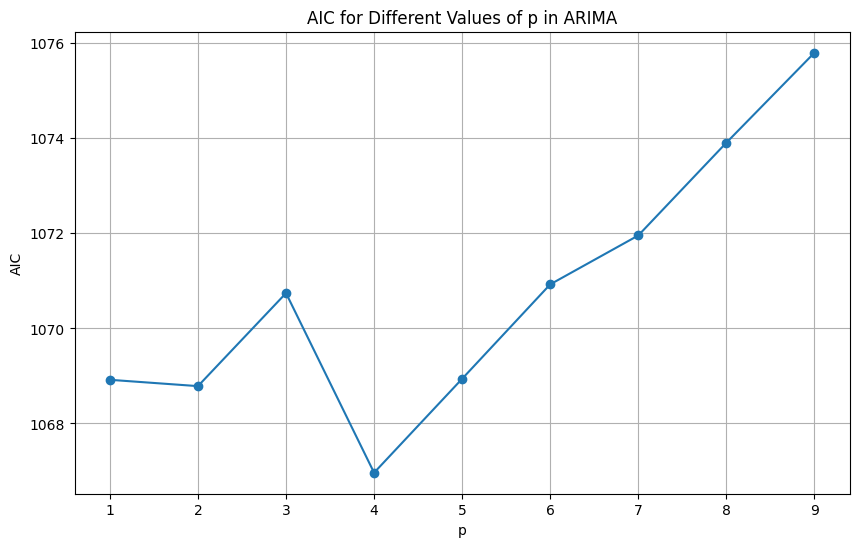

In [11]:
# Define the range of p, d, and q values
# p_values = range(1, 5)
d = 1
q = 0

# Define the range of p values
p_values = range(1, 10)

# Initialize lists to store AIC values
aic_values = []

# Iterate over each value of p
for p in p_values:
    # Fit the ARIMA model
    model = ARIMA(df_train['wPreis'], order=(p, d, q))
    result = model.fit()

    # Store the AIC value
    aic_values.append(result.aic)

# Plot the AIC values
plt.figure(figsize=(10, 6))
plt.plot(p_values, aic_values, marker='o', linestyle='-')
plt.xlabel('p')
plt.ylabel('AIC')
plt.title('AIC for Different Values of p in ARIMA')
plt.grid(True)
plt.xticks(p_values)
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA order parameters (p, d, q)
p = 4  # Autoregression order
d = 2  # Differencing order (0 for no differencing)
q = 0  # Moving Average order

# Fit the ARIMA model
test_model = ARIMA(df_train['wPreis'], order=(p, d, q))
test_result = test_model.fit()

# Print model summary
print(test_result.summary())

# Print AIC, BIC, and other evaluation metrics
print('AIC:', test_result.aic)
print('BIC:', test_result.bic)


                               SARIMAX Results                                
Dep. Variable:                 wPreis   No. Observations:                  178
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -539.879
Date:                Sat, 18 May 2024   AIC                           1089.759
Time:                        12:37:19   BIC                           1105.611
Sample:                             0   HQIC                          1096.189
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1276      0.078    -14.513      0.000      -1.280      -0.975
ar.L2         -0.9595      0.109     -8.815      0.000      -1.173      -0.746
ar.L3         -0.6097      0.106     -5.758      0.0

### Static forecast using ARIMA


No retraining. We just use the best ARIMA model to forecast for the test set and evaluate.
We use the once-trained best ARIMA model to forecast for the 6 "steps" in one go. 

In [13]:
model = ARIMA(df_train['wPreis'], order=(4, 2, 0))
static_ARIMA = model.fit()

In [14]:
static_ARIMA.forecast(steps=nobs) 

178    19.214558
179    20.182771
180    22.024503
181    23.388642
182    24.229856
183    25.436895
184    26.868479
185    28.099928
186    29.211877
Name: predicted_mean, dtype: float64

The ARIMA forecast function does not require an "input" other than the steps, so either
- we can do a static forecast (train once on the entire training dataset) and test the predictions for the required steps to compare with the test dataset or
- train in a walk-forward validation where we retrain the model with every step of the test dataset on the new training set which includes the new observation

In [15]:
fc = static_ARIMA.forecast(steps=nobs) 
a = np.array(fc)
df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])


In [16]:
df_test 

,week,wPreis,Plz,full,date
date,,,,,
2024-02-26,2024-09,22.155904,"['25', '24']",A1 & A2 - geschreddert,2024-02-26
2024-03-04,2024-10,14.056574,"['25', '24']",A1 & A2 - geschreddert,2024-03-04
2024-03-11,2024-11,5.704197,"['25', '24']",A1 & A2 - geschreddert,2024-03-11
2024-03-18,2024-12,21.771781,"['25', '24']",A1 & A2 - geschreddert,2024-03-18
2024-03-25,2024-13,5.372211,"['25', '24']",A1 & A2 - geschreddert,2024-03-25
2024-04-01,2024-14,-2.297377,"['25', '24']",A1 & A2 - geschreddert,2024-04-01
2024-04-08,2024-15,1.815280,"['25', '24']",A1 & A2 - geschreddert,2024-04-08
2024-04-15,2024-16,5.515964,"['25', '24']",A1 & A2 - geschreddert,2024-04-15
2024-04-22,2024-17,10.971897,"['25', '24']",A1 & A2 - geschreddert,2024-04-22


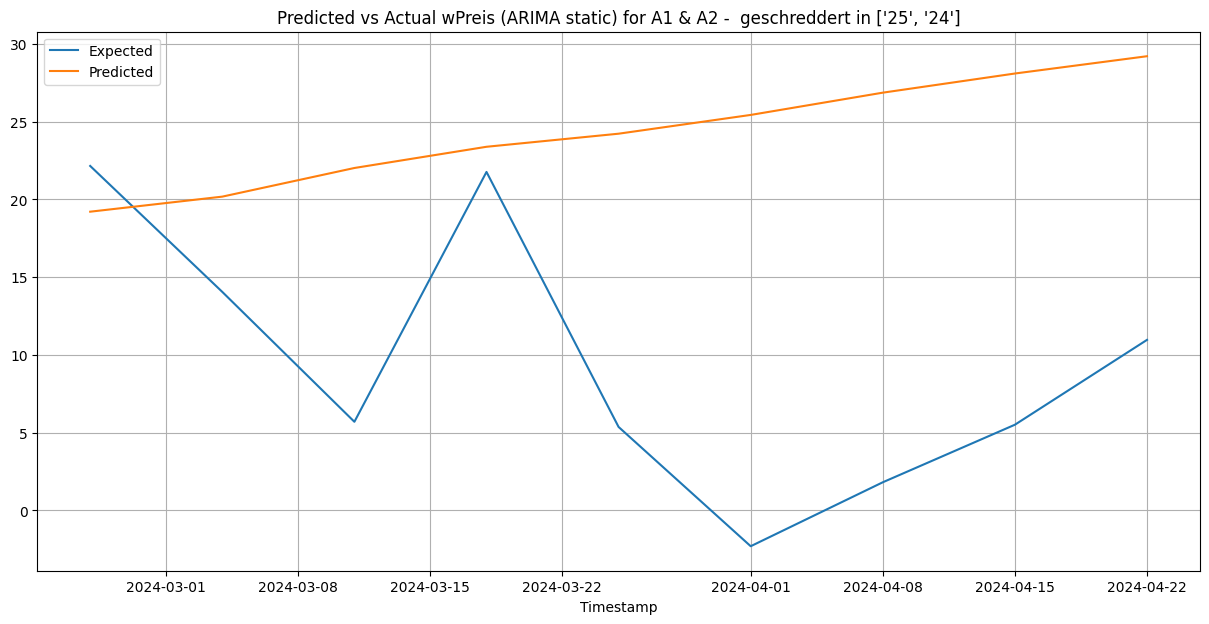

In [17]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], label='Expected')
plt.plot(df_forecast, label='Predicted')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title(f'Predicted vs Actual wPreis (ARIMA static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.show()

We will define a forecast accuracyy function that will calculate the mean error, RMSE and also the direction accuracy. 

In [18]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae':mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [19]:
df_test['full'].iloc[0]

'A1 & A2 -  geschreddert'

In [20]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print(f'Forecast Accuracy (ARIMA static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
stat_accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
print('MAE: %.3f' % stat_accuracy_prod['mae'])
print('ME: %.3f' % stat_accuracy_prod['me'])
print('RMSE: %.3f' % stat_accuracy_prod['rmse'])
print('Direction Accuracy: %.3f' % stat_accuracy_prod['direction_accuracy'])

Forecast Accuracy (ARIMA static) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 15.497
ME: 14.843
RMSE: 17.983
Direction Accuracy: 0.500


In [21]:
df_test["wPreis"]

date
2024-02-26    22.155904
2024-03-04    14.056574
2024-03-11     5.704197
2024-03-18    21.771781
2024-03-25     5.372211
2024-04-01    -2.297377
2024-04-08     1.815280
2024-04-15     5.515964
2024-04-22    10.971897
Name: wPreis, dtype: float64

# Walk forward validation using ARIMA model

Training the whole model at each iteration including the new observation (for the next day)  

In [22]:
history = [x for x in df_train['wPreis'].values]  
expect=[]

In [23]:
predictions = list()
for t in range(len(df_test)): # iterate over length of test dataset
    model = ARIMA(history, order=(4,2,0))  
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test['wPreis'][t]
    history.append(obs) # append the real observation at each loop
    expect.append(obs)


In [24]:
expect

[22.15590366581415,
 14.05657364458976,
 5.704196816208395,
 21.77178067233445,
 5.372211267352691,
 -2.297377039524063,
 1.815279903342731,
 5.515964309465752,
 10.97189655172414]

In [25]:
predictions

[19.214558489023997,
 22.751570666648057,
 17.581364255927852,
 7.71878966250498,
 17.237661207458874,
 4.663662194772527,
 -2.5896815042885404,
 -0.7253183716956917,
 -1.9883200059373078]

In [26]:
df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })


In [27]:
df_wPreis.index = df_test['wPreis'].index
df_wPreis

,observations,forecast
date,,
2024-02-26,22.155904,19.214558
2024-03-04,14.056574,22.751571
2024-03-11,5.704197,17.581364
2024-03-18,21.771781,7.718790
2024-03-25,5.372211,17.237661
2024-04-01,-2.297377,4.663662
2024-04-08,1.815280,-2.589682
2024-04-15,5.515964,-0.725318
2024-04-22,10.971897,-1.988320


In [28]:
def adjust(val, length= 10): return str(val).ljust(length) # 10
print(f'Forecast Accuracy (ARIMA Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
wf_accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
print('MAE: %.3f' % wf_accuracy_prod['mae'])
print('ME: %.3f' % wf_accuracy_prod['me'])
print('RMSE: %.3f' % wf_accuracy_prod['rmse'])
print('Direction Accuracy: %.3f' % wf_accuracy_prod['direction_accuracy'])

Forecast Accuracy (ARIMA Walk-forward) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 8.889
ME: -0.134
RMSE: 9.652
Direction Accuracy: 0.375


Here, the me and rmse has improved but the direction_accuracy has decreased even further!

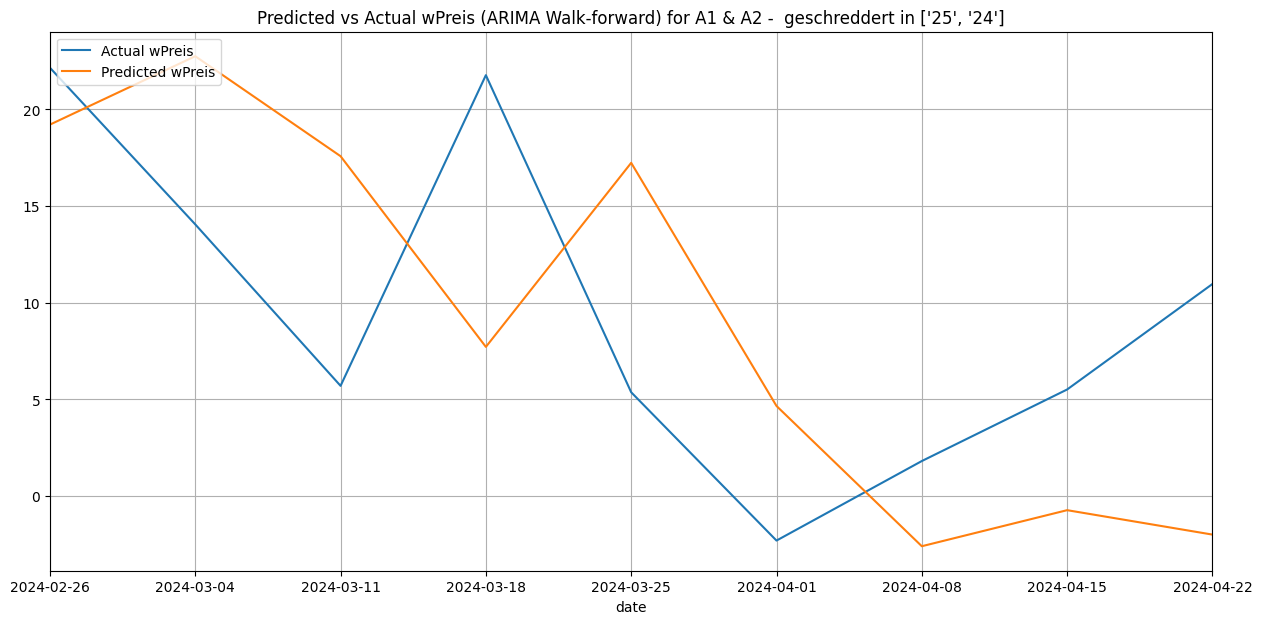

In [29]:

plt.figure(figsize=(15, 7))
plt.xlabel("Timestamp")

# Plot actual wPreis
ax1 = df_wPreis.observations.plot(grid=True, label='Actual wPreis')

# Plot predicted wPreis on secondary y-axis
# ax2 = df_wPreis.forecast.plot(grid=True, secondary_y=True, label='Predicted wPreis')
ax2 = df_wPreis.forecast.plot(grid=True, label='Predicted wPreis')

# Set x-axis ticks and labels to be the dates from the index
ax1.set_xticks(df_wPreis.index)
ax1.set_xticklabels(df_wPreis.index.strftime('%Y-%m-%d'))  # Format dates as desired

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title(f'Predicted vs Actual wPreis (ARIMA Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.show()

In [30]:
ARIMA_static = pd.DataFrame([stat_accuracy_prod])
ARIMA_walk_forward = pd.DataFrame([wf_accuracy_prod])

In [31]:
%store ARIMA_static
%store ARIMA_walk_forward


Stored 'ARIMA_static' (DataFrame)
Stored 'ARIMA_walk_forward' (DataFrame)


## All other clusters and categories

In [32]:
def forecast_accuracy(forecast, actual):
    mae = mean_absolute_error(actual, forecast)
    me = np.mean(forecast - actual)             # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # Direction accuracy
    forecast_diff = np.diff(forecast)
    actual_diff = np.diff(actual)
    direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))

    return {'mae':mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}

In [33]:
# For each dataset data
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]

    # Static forecast
    model = ARIMA(df_train['wPreis'], order=(4, 2, 0))
    static_ARIMA = model.fit()
    static_ARIMA.forecast(steps=nobs) 
    fc = static_ARIMA.forecast(steps=nobs) 
    a = np.array(fc)
    df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])

    # def adjust(val, length= 6): return str(val).ljust(length) # length
    # print(f'ARIMA static forecast Accuracy of: wPreis in {cluster} for {category}')
    return forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
    # for k, v in stat_accuracy_prod.items():
    #     print(adjust(k), ': ', round(v,4))




In [34]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    
    history = [x for x in df_train['wPreis'].values] # "list comprehensions". 
    expect=[]

    predictions = list()
    for t in range(len(df_test)): #  
        model = ARIMA(history, order=(4,2,0))  
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = df_test['wPreis'][t]
        history.append(obs) # appends the real observation at each loop! 
        expect.append(obs)

    df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })

    # def adjust(val, length= 10): return str(val).ljust(length) # 10
    # print(f'Walk-forward Validation Forecast Accuracy of wPreis in {cluster} for {category}')
    return forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
    # for k, v in wf_accuracy_prod.items():
    #     print(adjust(k), ': ', round(v,4))


    
 


In [35]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])





In [36]:
len(datasets)

33

In [37]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore') #, message="A date index has been provided, but it has no associated frequency information")

In [38]:
# Create an empty list to store dictionaries
data = []

# Loop through each category
for dataset in datasets:
    # Perform static forecast
    static_results = static_forecast(dataset)
    
    # Perform walk-forward forecast
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'ARIMA_static_mae': static_results['mae'],
        'ARIMA_static_me': static_results['me'],
        'ARIMA_static_rmse': static_results['rmse'],
        'ARIMA_static_direction_accuracy': static_results['direction_accuracy'],
        'ARIMA_wf_mae': wf_results['mae'],
        'ARIMA_wf_me': wf_results['me'],
        'ARIMA_wf_rmse': wf_results['rmse'],
        'ARIMA_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
# df_results

In [51]:
ARIMA_results = df_results
%store ARIMA_results


Stored 'ARIMA_results' (DataFrame)


In [39]:
df_results.to_csv('ARIMA_Results.csv')

In [40]:
df_results['Cluster'].unique()

array(["['25', '24']", "['80', '81', '82', '83', '84', '85', '93', '94']",
       "['70', '71', '73', '74', '75', '76']", "['50', '51', '52', '53']",
       "['40', '41', '42', '44', '45', '46', '47']", "['26', '27', '28']",
       "['48', '49']", "['20', '21', '22', '23']",
       "['10', '11', '12', '13', '14', '15', '16']",
       "['29', '30', '31', '38', '39']"], dtype=object)

In [41]:
df_results['Category'].unique()

array(['A2 -  geschreddert', 'A1 & A2 -  geschreddert',
       'A2 & A3 -  geschreddert', 'A3 -  geschreddert',
       'A2 & A3 -  ungeschreddert', 'A1 & A2 -  ungeschreddert',
       'A3 -  ungeschreddert'], dtype=object)

In [42]:
df_metrics = df_results[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse', 'ARIMA_static_direction_accuracy', 'ARIMA_wf_direction_accuracy']]

In [43]:
def getRMSEplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.35

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_rmse = df_plot['ARIMA_static_rmse']
    wf_rmse = df_plot['ARIMA_wf_rmse']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_rmse, bar_width, label='ARIMA Static RMSE')
    ax.barh([x + bar_width for x in ind], wf_rmse, bar_width, label='ARIMA Walk-forward RMSE')

    # Add RMSE values next to each bar
    for i, (s_rmse, wf_rmse) in enumerate(zip(static_rmse, wf_rmse)):
        ax.text(s_rmse, i, f'{s_rmse:.2f}', ha='right', va='center')
        ax.text(wf_rmse, i + bar_width, f'{wf_rmse:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Cluster')
    ax.set_title(f'RMSE comparison of Static and Walk-forward ARIMA across clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])
    
    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()

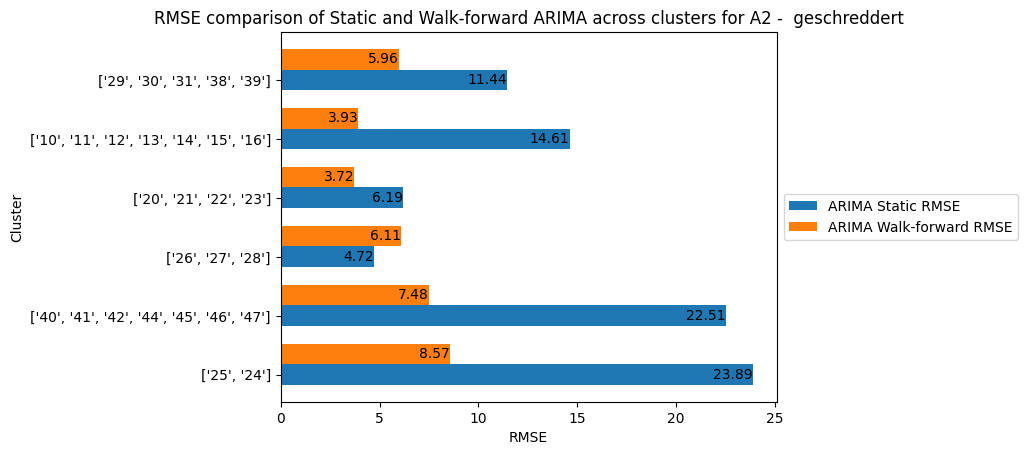

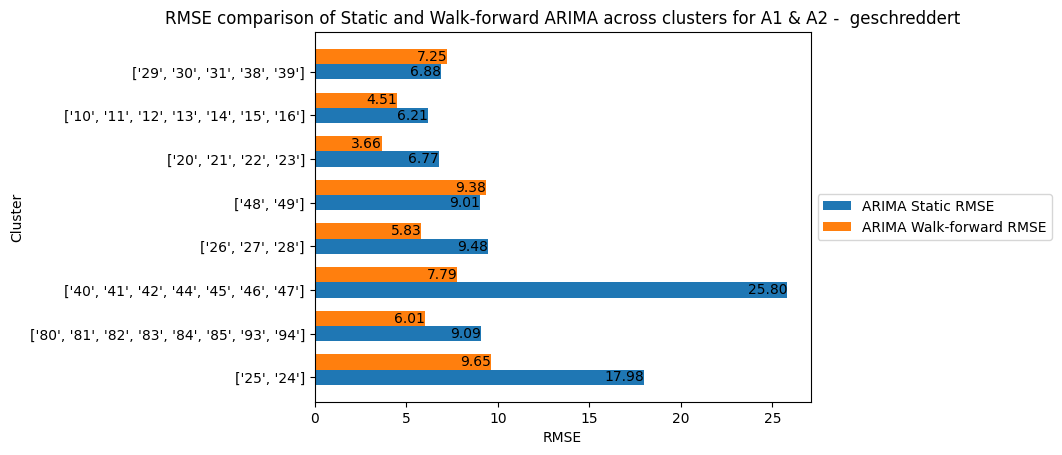

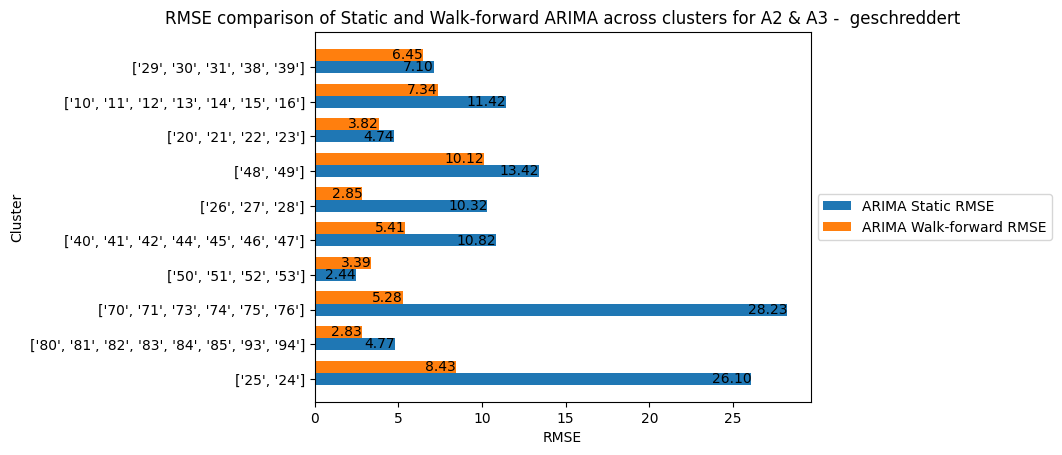

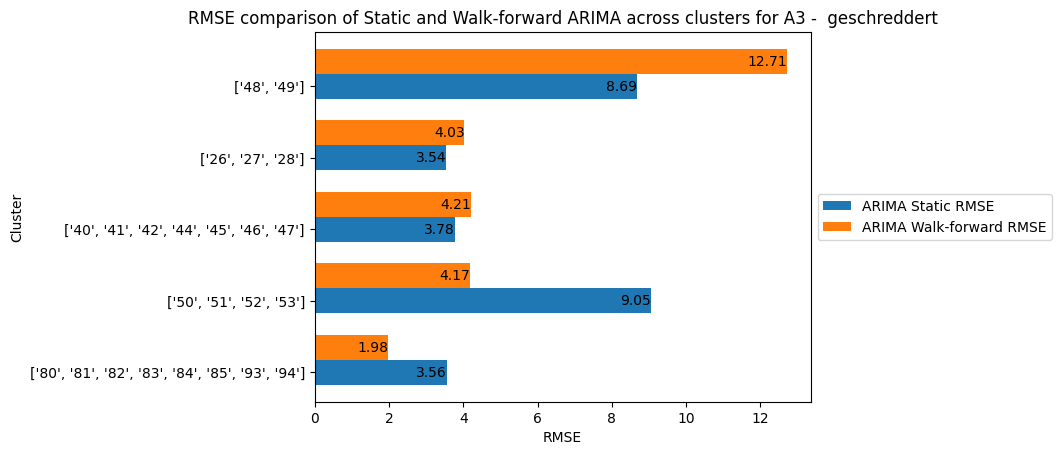

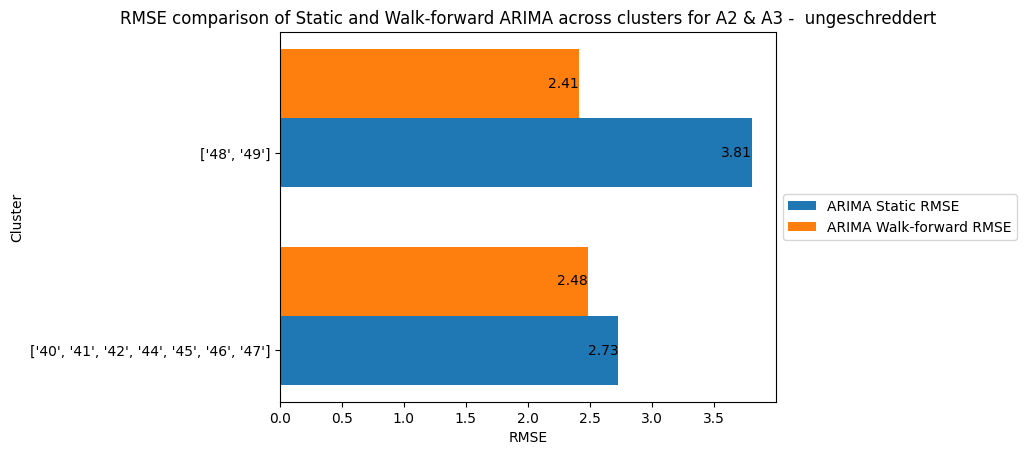

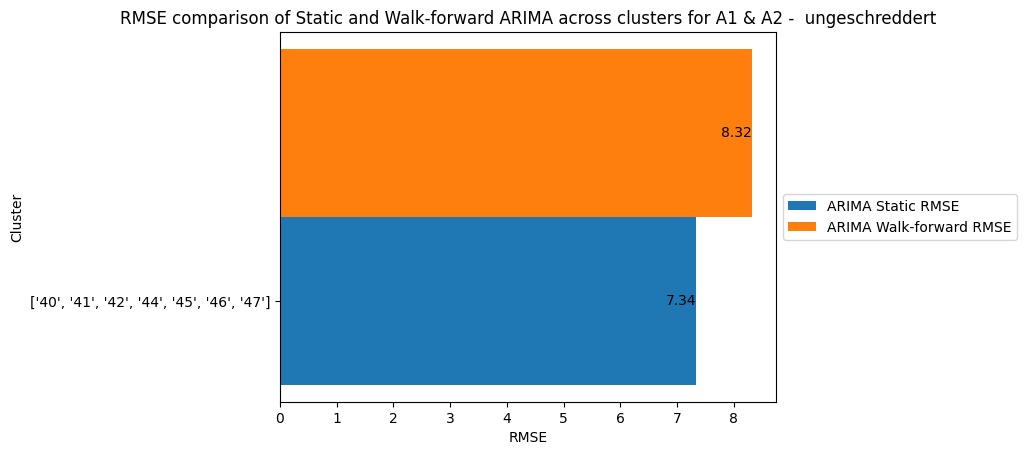

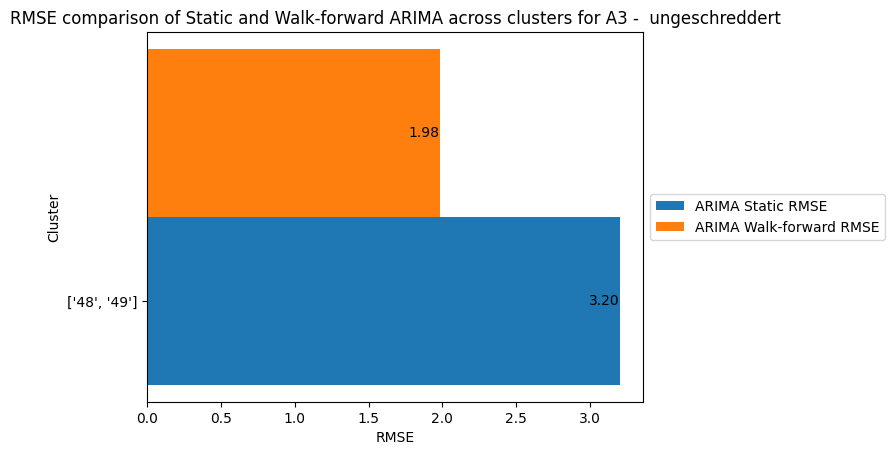

In [44]:
for category in df_metrics['Category'].unique():
   filtered = df_metrics[df_metrics['Category'] == category]
   getRMSEplot(filtered)

In [45]:
def getDirAccplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.35

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_dir_acc = df_plot['ARIMA_static_direction_accuracy']
    wf_dir_acc = df_plot['ARIMA_wf_direction_accuracy']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_dir_acc, bar_width, label='ARIMA Static Dir. Acc.')
    ax.barh([x + bar_width for x in ind], wf_dir_acc, bar_width, label='ARIMA Walk-forward Dir. Acc.')

    # Add direction accuracy values next to each bar
    for i, (s_dir_acc, wf_dir_acc) in enumerate(zip(static_dir_acc, wf_dir_acc)):
        ax.text(s_dir_acc, i, f'{s_dir_acc:.2f}', ha='right', va='center')
        ax.text(wf_dir_acc, i + bar_width, f'{wf_dir_acc:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('Direction Accuracy')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Direction accuracy comparison of Static and Walk-forward ARIMA across clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show plot
    plt.show()


In [46]:
# def getDirAccplot(df_plot):
#     # Create subplots
#     fig, ax = plt.subplots()

#     # Define bar width
#     bar_width = 0.35

#     # Define the positions for the bars
#     clusters = df_plot['Cluster']
#     static_dir_acc = df_plot['ARIMA_static_direction_accuracy']
#     wf_dir_acc = df_plot['ARIMA_wf_direction_accuracy']
#     ind = range(len(clusters))

#     # Plot the bars
#     ax.barh(ind, static_dir_acc, bar_width, label='ARIMA Static Direction Accuracy')
#     ax.barh([x + bar_width for x in ind], wf_dir_acc, bar_width, label='ARIMA Walk-Forward Direction Accuracy')

#     # Add direction accuracy values next to each bar
#     for i, (s_dir_acc, wf_dir_acc) in enumerate(zip(static_dir_acc, wf_dir_acc)):
#         ax.text(s_dir_acc, i, f'{s_dir_acc:.2f}', ha='right', va='center')
#         ax.text(wf_dir_acc, i + bar_width, f'{wf_dir_acc:.2f}', ha='right', va='center')

#     # Set labels and title
#     ax.set_xlabel('Direction Accuracy')
#     ax.set_ylabel('Cluster')
#     ax.set_title(f'Directional accuracy comparison of Static and Walk-Forward ARIMA across clusters for {df_plot["Category"].iloc[0]}')

#     # Set yticks and labels
#     ax.set_yticks(ind)
#     ax.set_yticklabels(df_plot['Cluster'])

#     # Add legend
#     ax.legend()

#     # Show plot
#     plt.show()

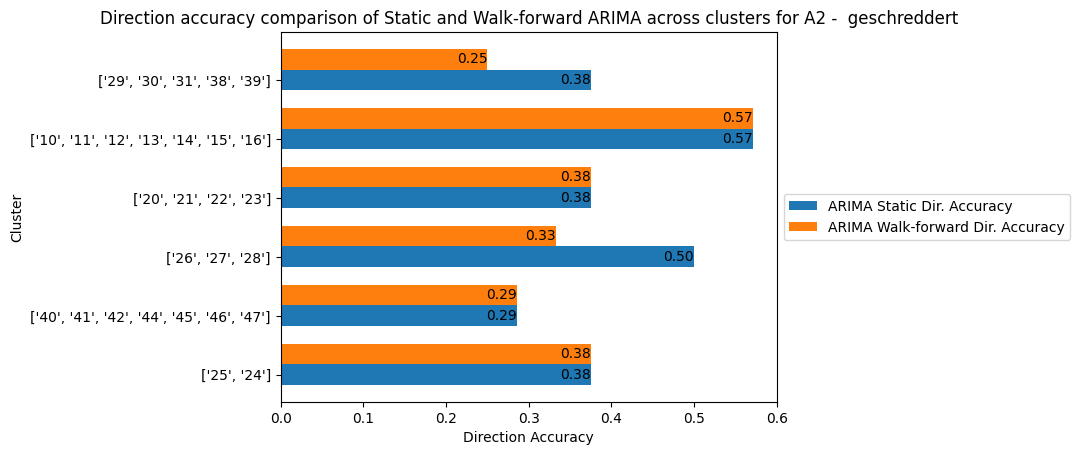

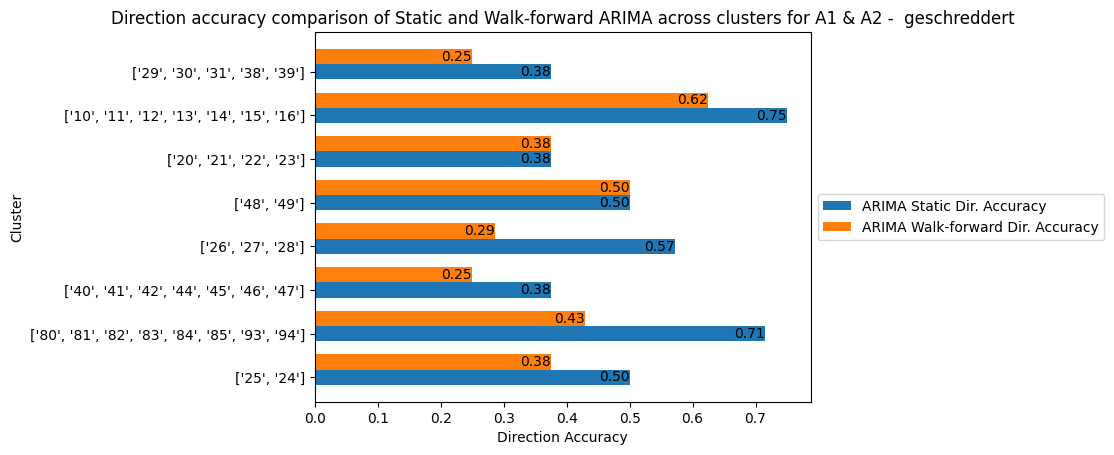

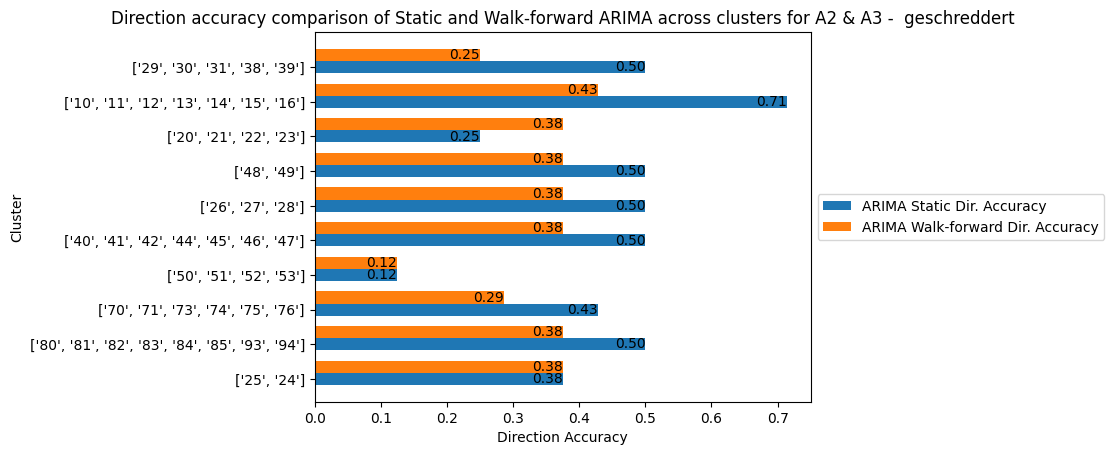

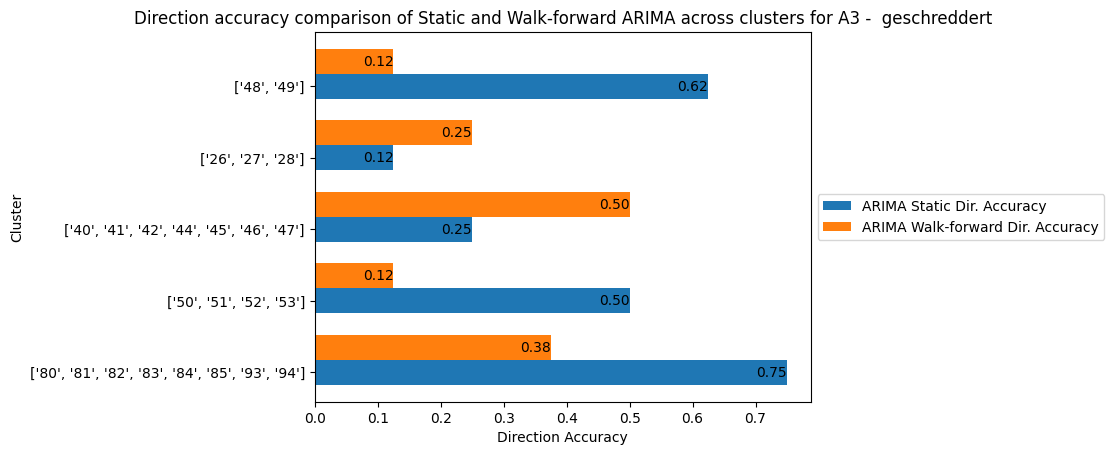

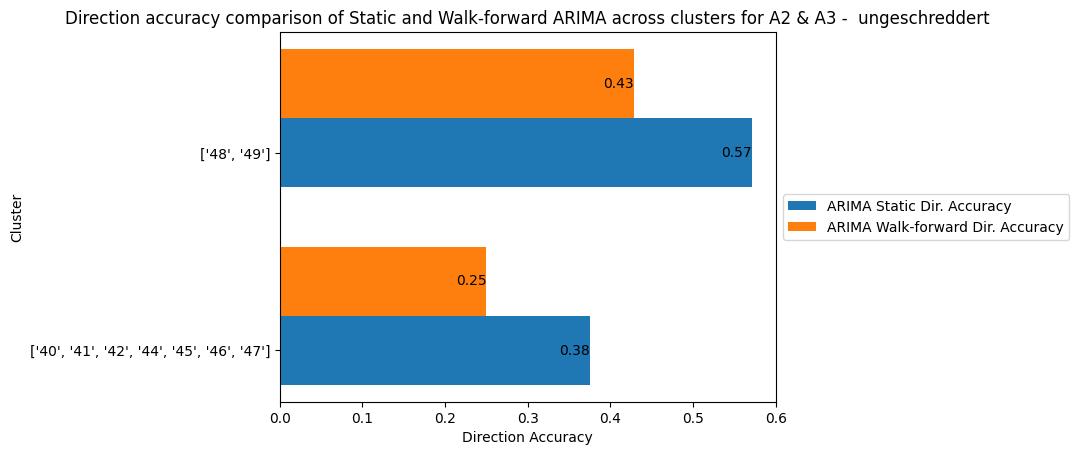

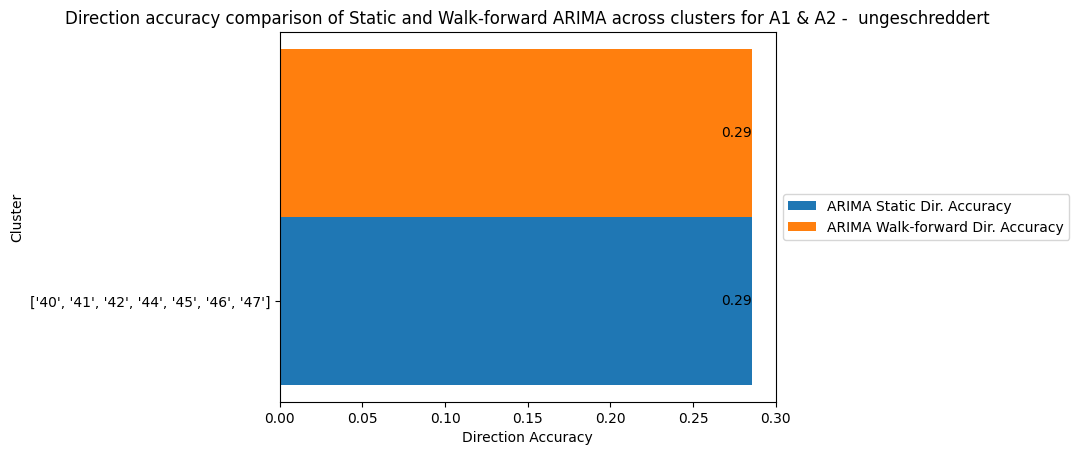

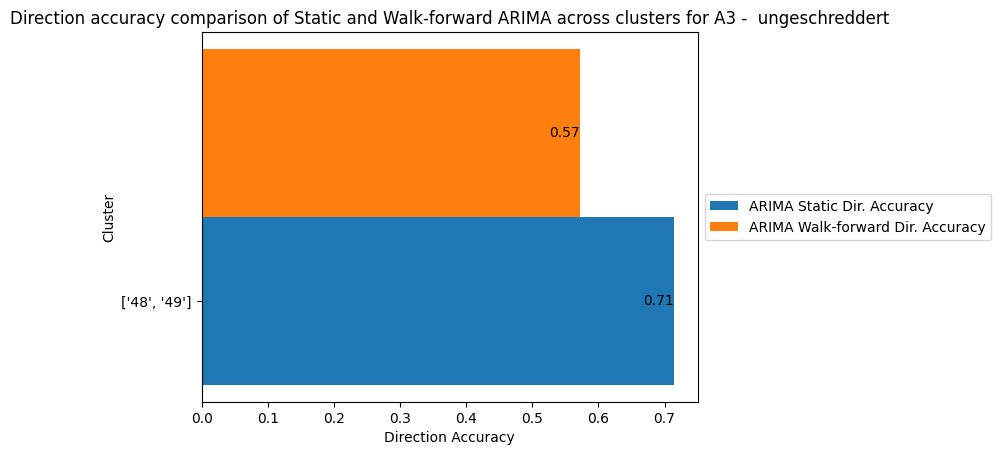

In [47]:
for category in df_metrics['Category'].unique():
   filtered = df_metrics[df_metrics['Category'] == category]
   getDirAccplot(filtered)

PLOTLY GRAPHS FOR THE SAME

In [48]:
# def getRMSEplot(df_plot):

#     # Filter the dataframe for only the required metrics
#     # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

#     # Create traces for each metric
#     traces = []
#     for metric in ['ARIMA_static_rmse', 'ARIMA_wf_rmse']:
#         trace = go.Bar(
#             x= df_plot[metric],
#             y= df_plot['Cluster'], 
#             name=metric,
#             orientation='h'
#         )
#         traces.append(trace)

#     # Define layout
#     layout = go.Layout(
#         title= f'RMSE comparison of Static and Walk-Forward ARIMA across clusters for {df_plot["Category"].iloc[0]}',
#         xaxis=dict(title='RMSE'),
#         yaxis=dict(title='Cluster'),
#         barmode='group'
#     )

#     # Create figure
#     fig = go.Figure(data=traces, layout=layout)

#     # Show figure
#     fig.show()


In [49]:
# def getDirAccplot(df_plot):

#     # Filter the dataframe for only the required metrics
#     # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

#     # Create traces for each metric
#     traces = []
#     for metric in ['ARIMA_static_direction_accuracy', 'ARIMA_wf_direction_accuracy']:
#         trace = go.Bar(
#             x= df_plot[metric],
#             y= df_plot['Cluster'], 
#             name=metric,
#             orientation='h'
#         )
#         traces.append(trace)

#     # Define layout
#     layout = go.Layout(
#         title= f'Directiona accuracy comparison of Static and Walk-Forward ARIMA across clusters for {df_plot["Category"].iloc[0]}',
#         xaxis=dict(title='Direction Accuracy'),
#         yaxis=dict(title='Cluster'),
#         barmode='group'
#     )

#     # Create figure
#     fig = go.Figure(data=traces, layout=layout)

#     # Show figure
#     fig.show()


In [50]:
# for category in df_metrics['Category'].unique():
#     filtered = df_metrics[df_metrics['Category'] == category]
#     getRMSEplot(filtered)
#     getDirAccplot(filtered)